In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gudhi as gd
from utilsTopology import *
from utilsBaricentricNeuralNetwork import *
from utils import *
fontsize=16
from tqdm import tqdm

plt.rcParams.update({
    "axes.titlesize": 14,    
    "axes.labelsize": fontsize,   
})

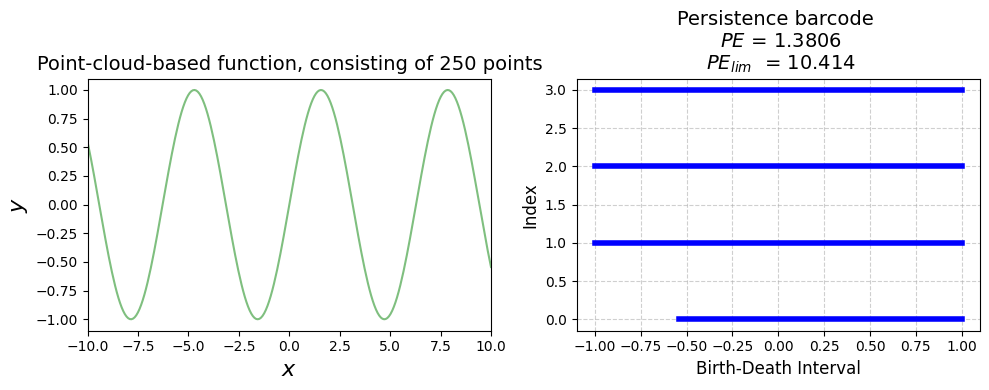

In [2]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)


stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # here we define that each element is connected to the next one, since what we have is a line formed by the points of the point cloud
layer = LowerStarLayer(simplextree=stbase)
dgms = layer.call(tf.Variable(y_train))
dgmRef = dgms[0][0]

entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(x_train, y_train,"g-", alpha=0.5)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Point-cloud-based function, consisting of 250 points')
plot_persistent_barcode(dgmRef,ax=axs[1])
axs[1].set_title(axs[1].get_title() + f" \n $PE$ = {round(entropyRef.numpy().item(),4)}")
axs[1].set_title(axs[1].get_title() + " \n $PE_{lim}$ " + f" = {round(entropyRefLim.numpy().item(),4)}")
fig.tight_layout()
plt.savefig('figures/WithoutNoiseUnknownFunctionPEVariants.png', dpi=300, bbox_inches='tight')
plt.show()

Persistent entropy ``measures'' the complexity of a topological space based on its persistence diagram $D = \{(b_i, d_i) \mid i \in I\}$

# Normal PE

$PE = - \sum_{i \in I} p_i \ln{p_i}$

where $p_i = \frac{\ell_i}{L}, \ell_i = d_i - b_i, L = \sum_{i \in I} \ell_i$.

\begin{equation}
    L_{PE} = |PE(ref) - PE(pred)|
\end{equation}

## Point cloud without noise

100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


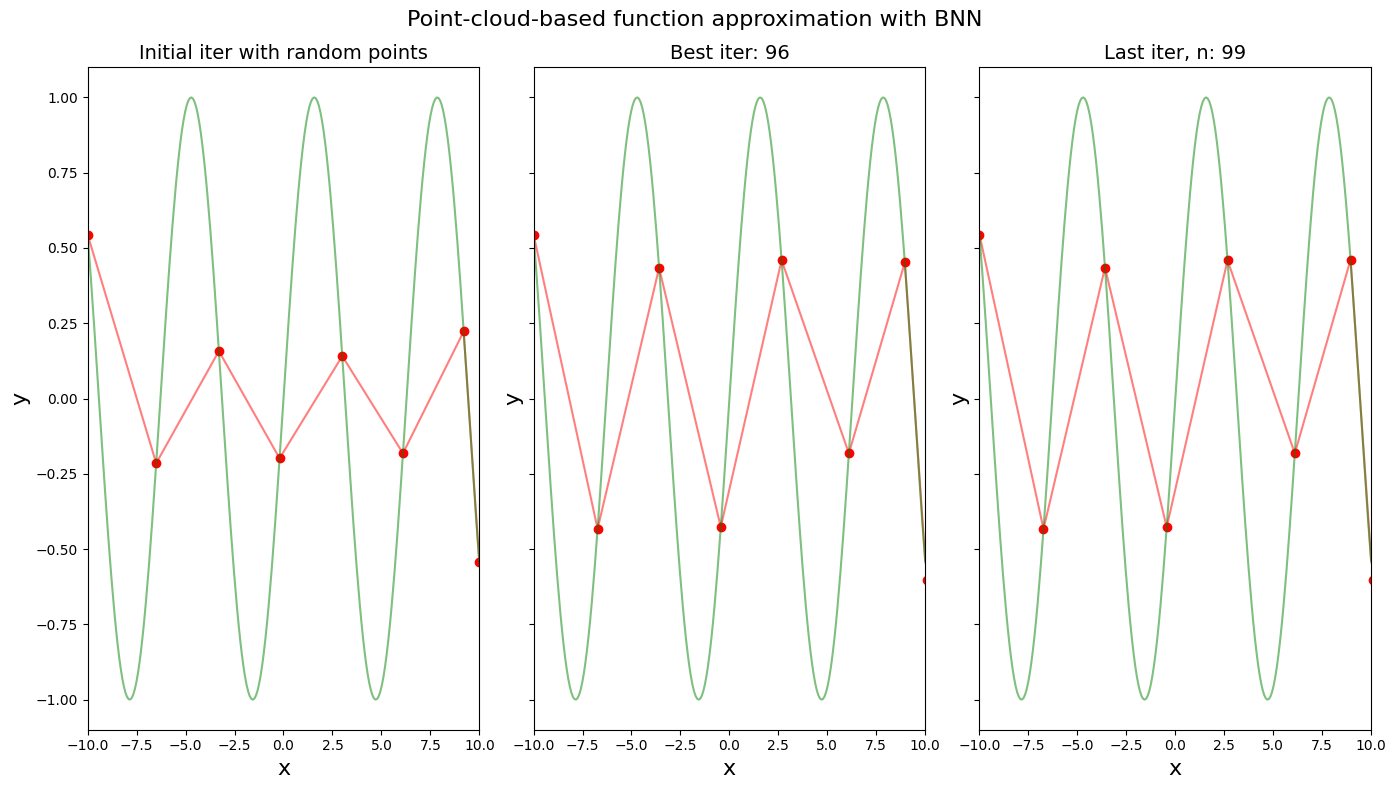

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)


stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
num_points_aprox = x_points.shape[0]

min_diff_entropy = float('inf')
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$PE$": [],
    f"$PE_{{lim}}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = PersistentEntropyLossTF()
        entropyLoss = lossFunction(dgmRef,dgmAprox)

    entropyAproxActual=persistent_entropy_tf(dgmAprox)
    entropyAproxActualLim=persistent_entropy_lim_tf(dgmAprox)
    
    metricas["$PE$"].append(entropyAproxActual.numpy().item())
    metricas[f"$PE_{{lim}}$"].append(entropyAproxActualLim.numpy().item())
    mseActual = tf.reduce_mean(tf.keras.losses.MSE(y_train, y_aprox))
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    gradients = tape.gradient(entropyLoss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points
        

    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_entropy = entropyAproxActual
        initial_entropyLim = entropyAproxActualLim
    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_entropy = entropyAproxActual
        best_entropyLim = entropyAproxActualLim

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_entropy = entropyAproxActual
        last_entropyLim = entropyAproxActualLim
        
    
metricasPE_wnoise  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(14, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithoutNoise_PE.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Point cloud with noise

100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


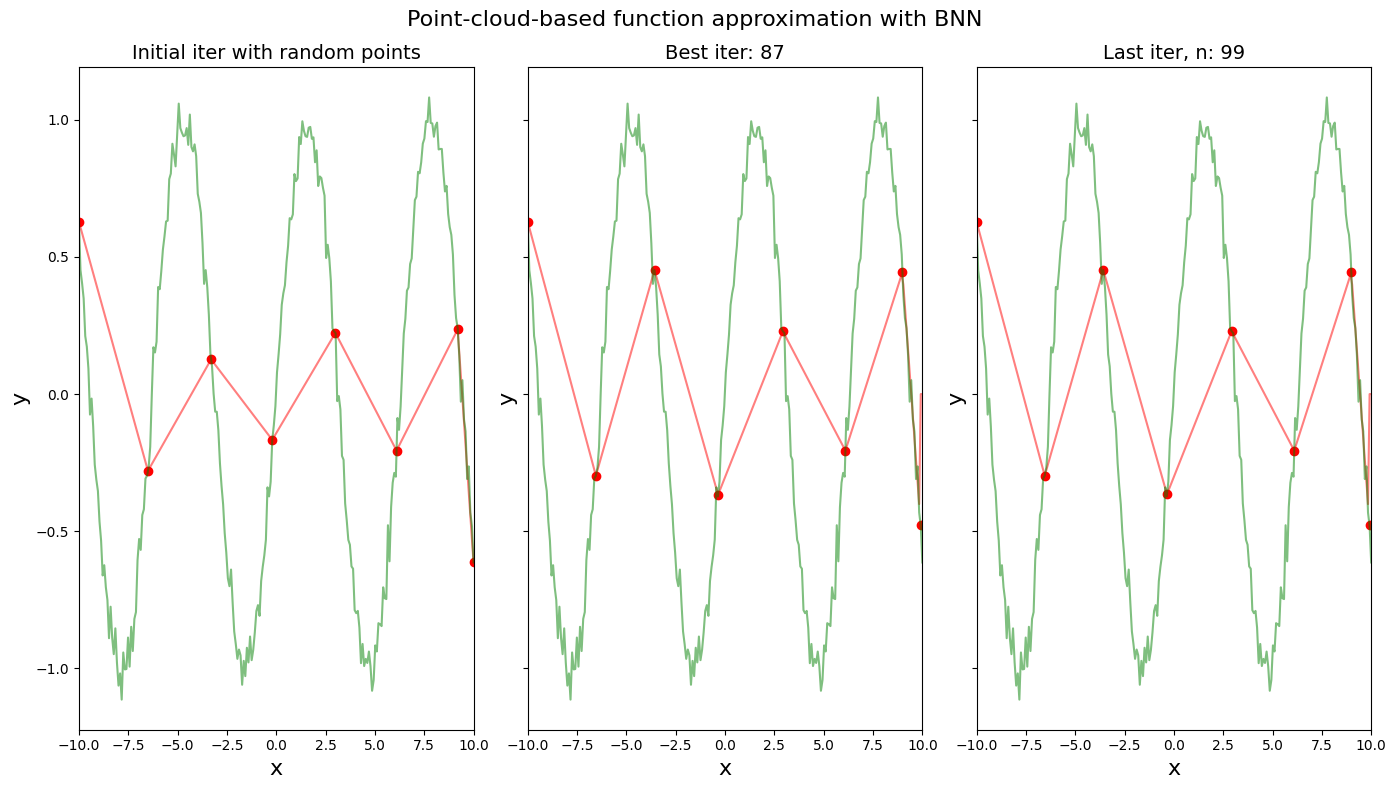

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
np.random.seed(7)
ruido = np.random.normal(0, 0.05, size=x_train.shape)
y_train = y_train + ruido
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)


stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
num_points_aprox = x_points.shape[0]

min_diff_entropy = float('inf')
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$PE$": [],
    f"$PE_{{lim}}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = PersistentEntropyLossTF()
        entropyLoss = lossFunction(dgmRef,dgmAprox)

    entropyAproxActual=persistent_entropy_tf(dgmAprox)
    entropyAproxActualLim=persistent_entropy_lim_tf(dgmAprox)
    
    metricas["$PE$"].append(entropyAproxActual.numpy().item())
    metricas[f"$PE_{{lim}}$"].append(entropyAproxActualLim.numpy().item())
    mseActual = tf.reduce_mean(tf.keras.losses.MSE(y_train, y_aprox))
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    gradients = tape.gradient(entropyLoss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points
        

    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_entropy = entropyAproxActual
        initial_entropyLim = entropyAproxActualLim
    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_entropy = entropyAproxActual
        best_entropyLim = entropyAproxActualLim

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_entropy = entropyAproxActual
        last_entropyLim = entropyAproxActualLim
        
    
metricasPE_wnoise  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(14, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithNoise_PE.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Lim PE

$PE_{lim}(x) = - \sum_{i \in I} l_i \times \ln p_i$

where $p_i = \frac{\ell_i}{L}, \ell_i = d_i - b_i, L = \sum_{i \in I} \ell_i$.

\begin{equation}
    L_{PE_{lim}} = |PE_{lim}(ref) - PE_{lim}(pred)|
\end{equation}

## Point cloud without noise

100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


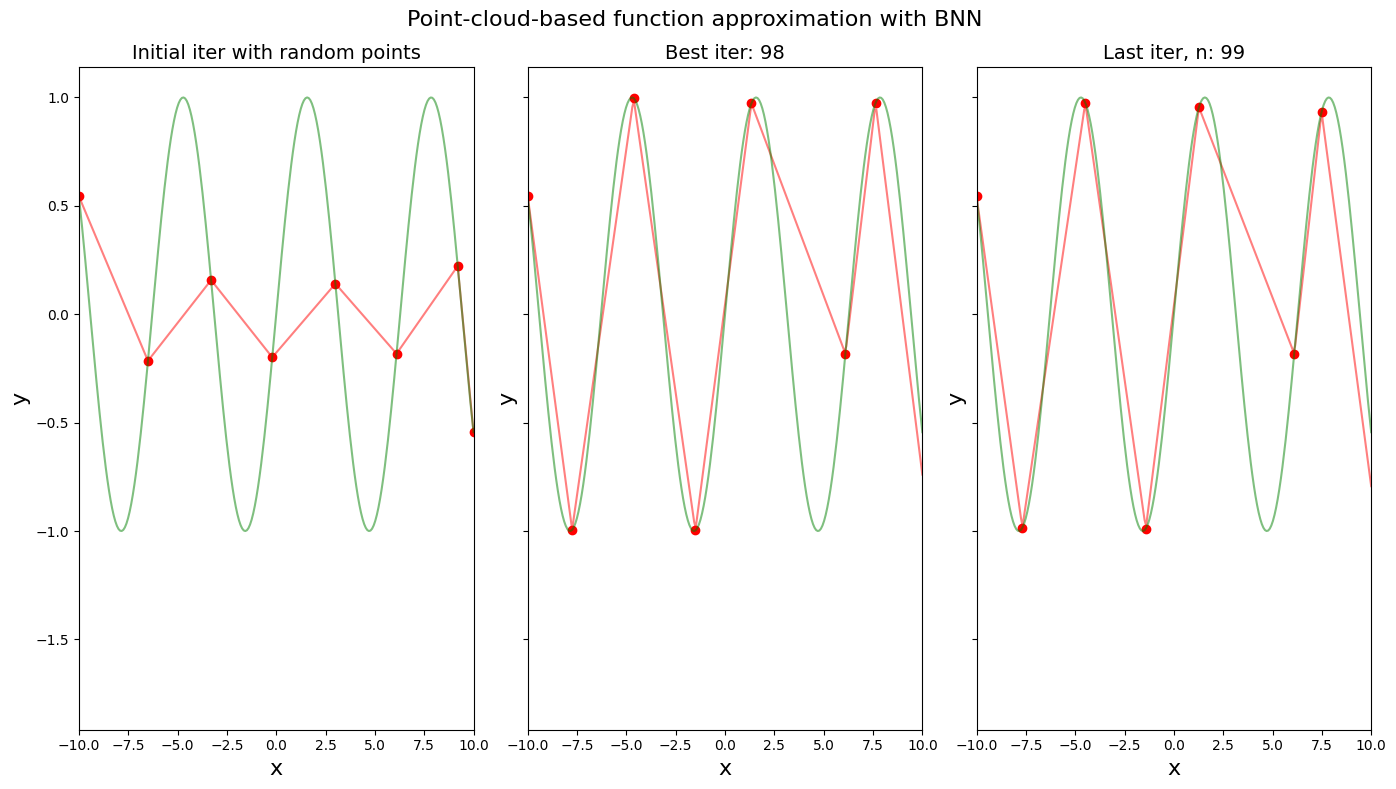

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)


stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
num_points_aprox = x_points.shape[0]

min_diff_entropy = float('inf')
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$PE$": [],
    f"$PE_{{lim}}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = PersistentEntropyLossLimTF()
        entropyLoss = lossFunction(dgmRef,dgmAprox)

    entropyAproxActual=persistent_entropy_tf(dgmAprox)
    entropyAproxActualLim=persistent_entropy_lim_tf(dgmAprox)
    
    metricas["$PE$"].append(entropyAproxActual.numpy().item())
    metricas[f"$PE_{{lim}}$"].append(entropyAproxActualLim.numpy().item())
    mseActual = tf.reduce_mean(tf.keras.losses.MSE(y_train, y_aprox))
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    gradients = tape.gradient(entropyLoss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points
        

    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_entropy = entropyAproxActual
        initial_entropyLim = entropyAproxActualLim
    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_entropy = entropyAproxActual
        best_entropyLim = entropyAproxActualLim

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_entropy = entropyAproxActual
        last_entropyLim = entropyAproxActualLim
        
    
metricasPE_wnoise  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(14, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithoutNoise_PElim.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Point cloud with noise

100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


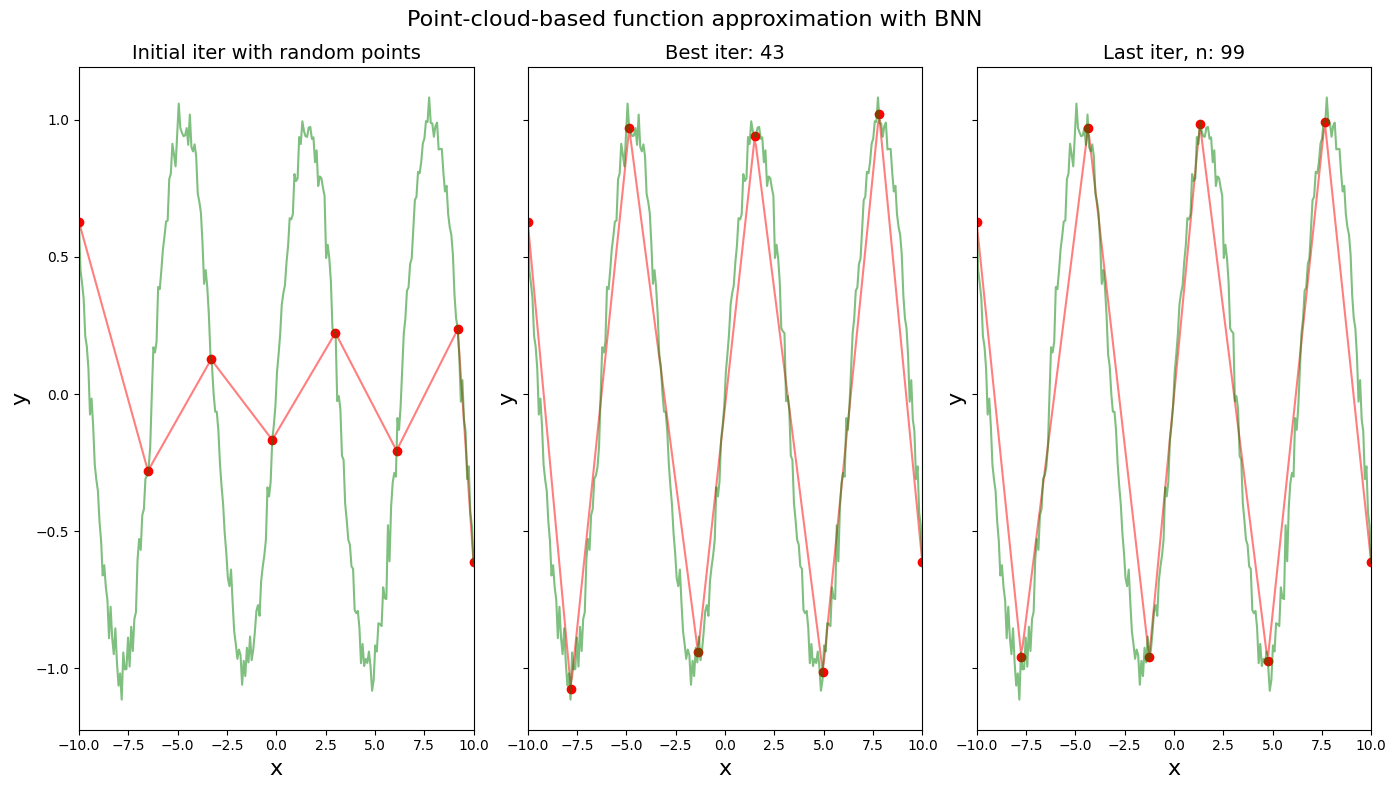

In [9]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
np.random.seed(7)
ruido = np.random.normal(0, 0.05, size=x_train.shape)
y_train = y_train + ruido
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)


stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
num_points_aprox = x_points.shape[0]

min_diff_entropy = float('inf')
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$PE$": [],
    f"$PE_{{lim}}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = PersistentEntropyLossLimTF()
        entropyLoss = lossFunction(dgmRef,dgmAprox)

    entropyAproxActual=persistent_entropy_tf(dgmAprox)
    entropyAproxActualLim=persistent_entropy_lim_tf(dgmAprox)
    
    metricas["$PE$"].append(entropyAproxActual.numpy().item())
    metricas[f"$PE_{{lim}}$"].append(entropyAproxActualLim.numpy().item())
    mseActual = tf.reduce_mean(tf.keras.losses.MSE(y_train, y_aprox))
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    gradients = tape.gradient(entropyLoss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points
        

    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_entropy = entropyAproxActual
        initial_entropyLim = entropyAproxActualLim
    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_entropy = entropyAproxActual
        best_entropyLim = entropyAproxActualLim

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_entropy = entropyAproxActual
        last_entropyLim = entropyAproxActualLim
        
    
metricasPE_wnoise  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(14, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithNoise_PElim.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Comparing them

## Without noise

NameError: name 'metricasPElim_wnoise' is not defined

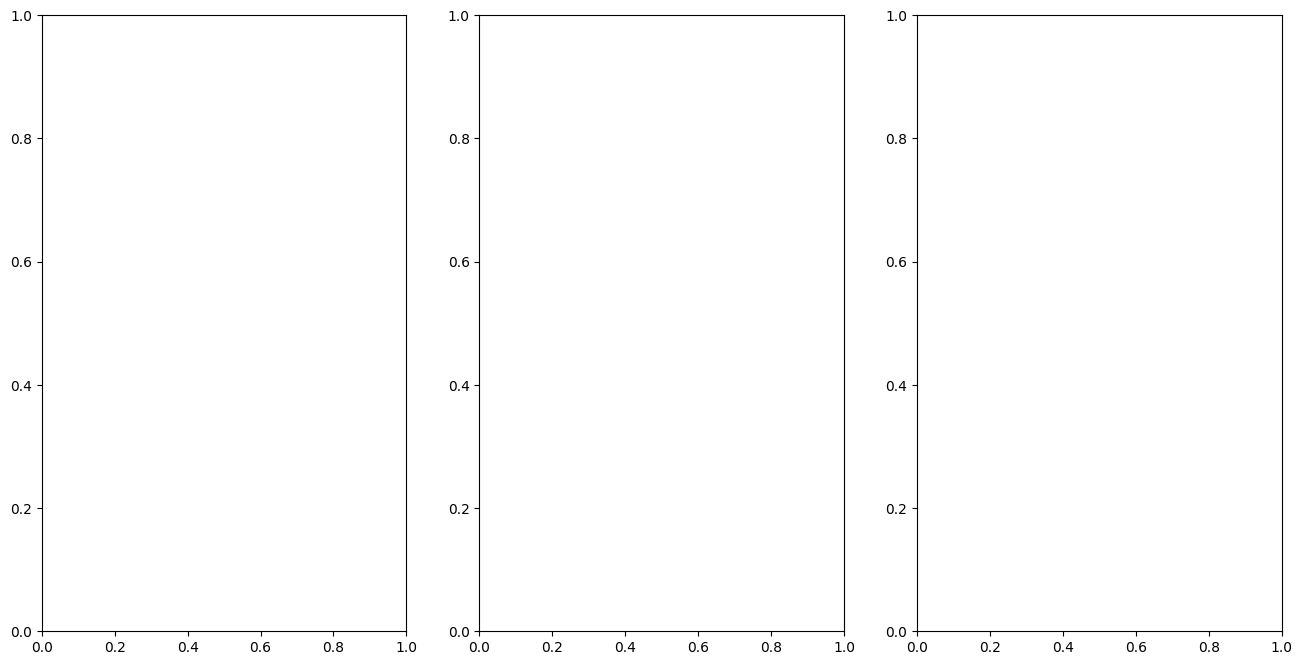

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=True)
axes = axes.flatten()
labels = ["$L_{PE}$", "$L_{PE_{lim}}$"]

for i, metric in enumerate([metricasPE_wnoise, metricasPElim_wnoise]):
    for num, (nombre, metrica) in enumerate(metric.items(), start=0):
        plt.sca(axes[num])
        plt.plot(metrica, label=labels[i])  # Solo estos labels irán en la leyenda global
        plt.title(f"Learning curve {nombre}", fontsize=20)
        plt.xlabel("Step")
        plt.ylabel(f"{nombre}")

        # Agregar líneas de referencia solo dentro del subgráfico
        if num == 1:
            axes[num].axhline(y=entropyRef, color='red', linestyle='--')
            axes[num].text(len(metrica) * 0.7, entropyRef+0.001, "$PE$ reference", color='red', fontsize=12)

        if num == 2:
            axes[num].axhline(y=entropyRefLim, color='red', linestyle='--')
            axes[num].text(len(metrica) * 0.7, entropyRefLim+0.1, "$PE_{lim}$ reference", color='red', fontsize=12)

# Solo mostrar la leyenda de plt.plot()
plt.legend(bbox_to_anchor=(1, 1), fontsize=20)
plt.tight_layout()
plt.savefig('figures/WithoutNoiseComparisonPE.png', dpi=300, bbox_inches='tight')
plt.show()


$L_{PE_{lim}}$ is better

## With noise

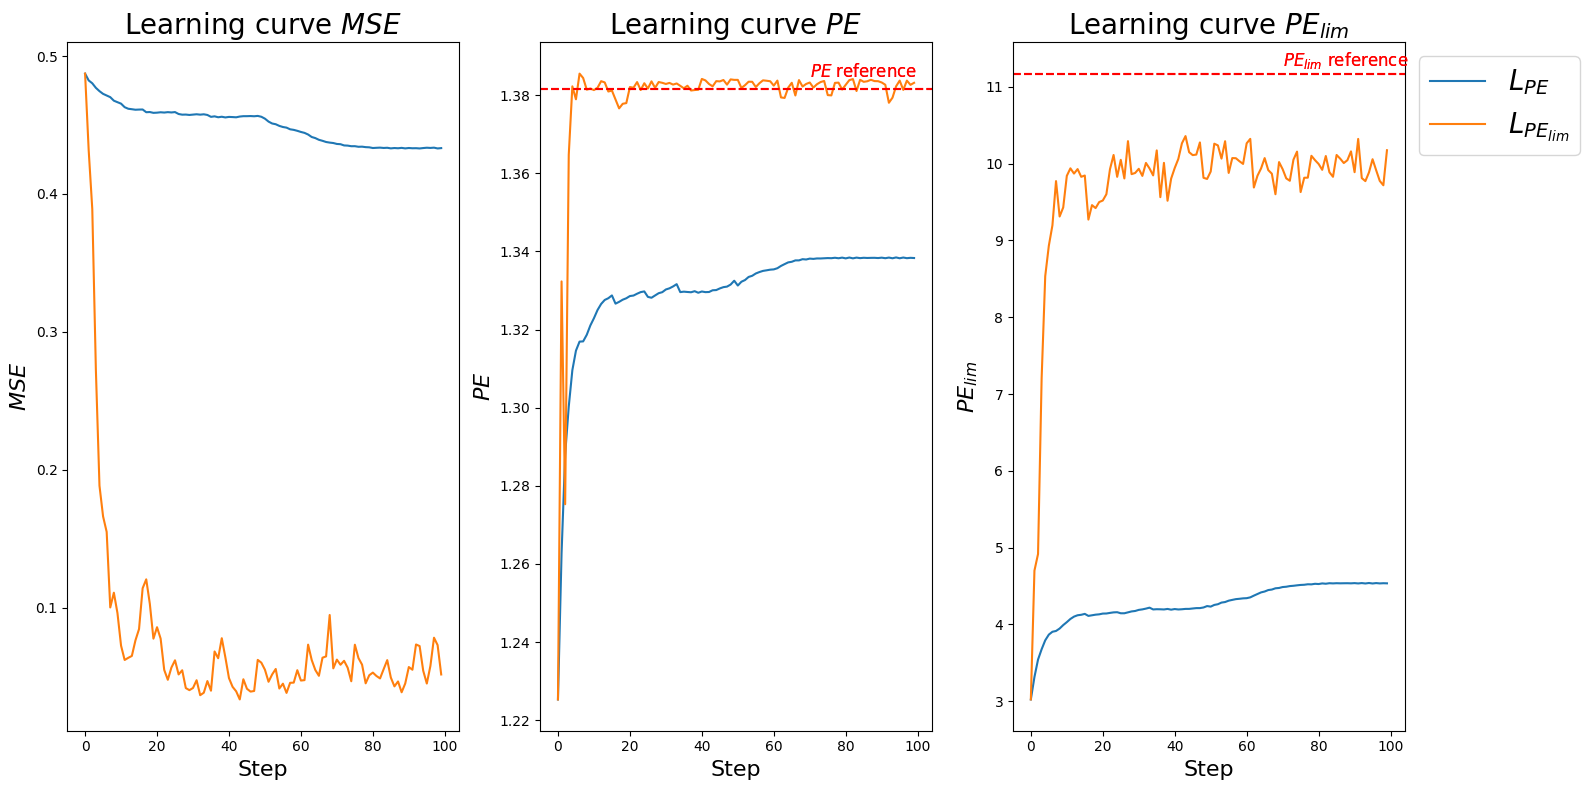

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=True)
axes = axes.flatten()
labels = ["$L_{PE}$", "$L_{PE_{lim}}$"]

for i, metric in enumerate([metricasPE_noise, metricasPElim_noise]):
    for num, (nombre, metrica) in enumerate(metric.items(), start=0):
        plt.sca(axes[num])
        plt.plot(metrica, label=labels[i])  # Solo estos labels irán en la leyenda global
        plt.title(f"Learning curve {nombre}", fontsize=20)
        plt.xlabel("Step")
        plt.ylabel(f"{nombre}")

        # Agregar líneas de referencia solo dentro del subgráfico
        if num == 1:
            axes[num].axhline(y=entropyRef, color='red', linestyle='--')
            axes[num].text(len(metrica) * 0.7, entropyRef+0.003, "$PE$ reference", color='red', fontsize=12)

        if num == 2:
            axes[num].axhline(y=entropyRefLim, color='red', linestyle='--')
            axes[num].text(len(metrica) * 0.7, entropyRefLim+0.1, "$PE_{lim}$ reference", color='red', fontsize=12)

# Solo mostrar la leyenda de plt.plot()
plt.legend(bbox_to_anchor=(1, 1), fontsize=20)
plt.tight_layout()
plt.savefig('figures/WithNoiseComparisonPE.png', dpi=300, bbox_inches='tight')
plt.show()

$L_{PE_{lim}}$ is better